In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./EF_comp.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Project number                                198 non-null    object 
 1   The date                                      198 non-null    object 
 2   Region                                        198 non-null    object 
 3   The town/village                              191 non-null    object 
 4   Home address                                  198 non-null    object 
 5   County/City                                   198 non-null    object 
 6   Initial year of exploitation                  198 non-null    int64  
 7   Building Total Area                           198 non-null    float64
 8   Room volume                                   198 non-null    float64
 9   Average floor height                          198 non-null    flo

In [3]:
feature_cols = ['Building Total Area','Reference area','Above-ground floors',
                'Underground floor','Energy consumption before',
                'Initial energy class ','Energy class after']
target_cols = ['Carrying out construction works ','Reconstruction of engineering systems',
                'Heat installation','Water heating system']

categorical_cols = ['Above-ground floors','Underground floor',
                    'Carrying out construction works',
                    'Reconstruction of engineering systems',
                    'Heat installation','Water heating system']

df = df[df.columns[df.columns.isin(feature_cols+target_cols)]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Building Total Area                    198 non-null    float64
 1   Reference area                         198 non-null    float64
 2   Above-ground floors                    198 non-null    int64  
 3   Underground floor                      198 non-null    int64  
 4   Initial energy class                   198 non-null    object 
 5   Energy consumption before              198 non-null    float64
 6   Carrying out construction works        198 non-null    int64  
 7   Reconstruction of engineering systems  198 non-null    int64  
 8   Water heating system                   198 non-null    int64  
 9   Heat installation                      198 non-null    int64  
 10  Energy class after                     198 non-null    object 
dtypes: flo

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

for col in df.columns:
    if is_numeric_dtype(df[col]):
        df[[col]] = MinMaxScaler().fit_transform(df[[col]])

for col in df.columns:
    if is_string_dtype(df[col]):
        df[col] = LabelEncoder().fit_transform(df[col])


Xfeatures = df[feature_cols]
ylabels = df[target_cols]

train_X,test_X,train_Y,test_Y = train_test_split(Xfeatures,ylabels,test_size=0.2,random_state=7)
train_X, validation_X, train_Y, validation_Y = train_test_split(train_X, train_Y, test_size=0.25, random_state=1, shuffle=True) # 0.25 x 0.8 = 0.2


In [5]:
# from sklearn.neural_network import MLPClassifier

# classifier  = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = 'relu', 
#                             solver='adam', shuffle=True, random_state=1, #,verbose=True, early_stopping=True
#                             learning_rate='adaptive').fit(train_X, train_Y)
# classifier.fit(train_X, train_Y)
# pred_Y = classifier.predict(validation_X)


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix
import pickle

#Set the parameters of each model by cross-validation gridsearch
#from custom-perceptron import my_perceptron
models = {'KNN': KNeighborsClassifier(),
          'SVC': OneVsRestClassifier(SVC()),
          'LR': OneVsRestClassifier(LogisticRegression()),
        #   'GNB': OneVsRestClassifier(GaussianNB()),
          'DT': DecisionTreeClassifier(),
          'RF': RandomForestClassifier(n_jobs=-1), 
          'MLP': MLPClassifier(learning_rate='adaptive',shuffle=True, max_iter=500),
          'XGB': XGBClassifier()}

param_grid = [{'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'KNN__weights': ['uniform', 'distance']},
              {'SVC__estimator__kernel': ['rbf', 'linear'], 'SVC__estimator__gamma': ['scale', 'auto'], 'SVC__estimator__C': [10, 100, 1000]},
              {'LR__estimator__penalty': ['l1', 'l2'], 'LR__estimator__C': [1.0, 0.5, 0.1], 'LR__estimator__solver': ['lbfgs','liblinear']},
            #   {'GNB__priors':[None, [0.5,0.5], [0.1, 0.9], [0.000001,0.99999], [0.000000001,0.99999999]]},
              {'DT__criterion': ['entropy'], 'DT__max_depth': [6], 'DT__min_samples_leaf': [1], 'DT__min_samples_split': [4]},
              {'RF__n_estimators': [200, 600], 'RF__max_depth': [4, 10, None], 'RF__min_samples_leaf': [1, 2, 5]},
              {'MLP__hidden_layer_sizes': [150,100,50], 'MLP__activation':['relu','logistic','tanh'], 
               'MLP__solver': ['adam','lbfgs','sgd']}, #,verbose=True, early_stopping=True
              {'XGB__learning_rate': [.1,.2,.3], 'XGB__max_depth': [1, 2, 3, 4, 5, 6], 'XGB__min_child_weight': [1,2],
               'XGB__subsample': [1.0, 0.5, 0.1], 'XGB__n_estimators': [200, 600]}]

def modelSearch():
  best_scores=[]
  params=[]

  for (classifier, model_params, name) in list(zip(models.values(), param_grid, models.keys())):
      print(f"\nTuning hyper-parameters, based on accuracy for {name} with parameter grid: {model_params}")

      pipe = Pipeline([(name, models[name])])
      clf = GridSearchCV(estimator=pipe, param_grid=model_params, cv=5, scoring='accuracy', n_jobs=-1)    
      clf.fit(train_X, train_Y) 

      # print(f"Mean performance of each parameter combination based on Cross Validation")
      # performance = pd.DataFrame(clf.cv_results_['params'])
      # performance["Score"] = clf.cv_results_['mean_test_score']
      # print(performance)

      # print("\nBest parameters set found on training set:")
      # print(clf.best_params_)
      # params.append(clf.best_params_)

      # print("\nThe scores are computed on the full evaluation set:")
      #evaluate and store scores of estimators of each category on validation set
      score = clf.score(test_X, test_Y)
      print("Accuracy:", score)
      best_scores.append(score)

      with open(f'{name}.pkl', 'wb+') as f: pickle.dump(clf, f)
      
      # pred_Y = clf.predict(test_X)
      # print(metrics.classification_report(test_Y, pred_Y, digits=5))
      # confusion_matrices = multilabel_confusion_matrix(test_Y, pred_Y)
      # for i, cm in enumerate(confusion_matrices):
      #     print(f"Confusion Matrix for Class \"{target_cols[i]}\":\n {cm}\n")
          
      #     # ax, labels, title and ticks
      #     ax= plt.subplot();
      #     sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Greens);  #annot=True to annotate cells, ftm='g' to disable scientific notation
      #     ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');  
      #     ax.set_xticklabels(['No','Yes']); ax.set_yticklabels(['No','Yes'])
      #     print(f"True Positives: {cm[1,1]}, False Positives: {cm[0,1]}, True Negatives: {cm[0,0]}, False Negatives: {cm[1,0]} \n\n")
      #     plt.title(target_cols[i]); plt.show()
  return best_scores

best_scores = modelSearch()
final_scores = dict(zip(list(models.keys()), best_scores))


Tuning hyper-parameters, based on accuracy for KNN with parameter grid: {'KNN__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15], 'KNN__weights': ['uniform', 'distance']}
Accuracy: 0.425

Tuning hyper-parameters, based on accuracy for OVRSVC with parameter grid: {'OVRSVC__estimator__kernel': ['rbf', 'linear'], 'OVRSVC__estimator__gamma': ['scale', 'auto'], 'OVRSVC__estimator__C': [10, 100, 1000]}
Accuracy: 0.55

Tuning hyper-parameters, based on accuracy for OVRLR with parameter grid: {'OVRLR__estimator__penalty': ['l1', 'l2'], 'OVRLR__estimator__C': [1.0, 0.5, 0.1], 'OVRLR__estimator__solver': ['lbfgs']}


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packa

Accuracy: 0.45

Tuning hyper-parameters, based on accuracy for DT with parameter grid: {'DT__criterion': ['entropy'], 'DT__max_depth': [6], 'DT__min_samples_leaf': [1], 'DT__min_samples_split': [4]}
Accuracy: 0.45

Tuning hyper-parameters, based on accuracy for RF with parameter grid: {'RF__n_estimators': [200, 600], 'RF__max_depth': [4, 10, None], 'RF__min_samples_leaf': [1, 2, 5]}
Accuracy: 0.475

Tuning hyper-parameters, based on accuracy for MLP with parameter grid: {'MLP__hidden_layer_sizes': [150, 100, 50], 'MLP__activation': ['relu', 'logistic', 'tanh'], 'MLP__solver': ['adam', 'lbfgs', 'sgd']}


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.425

Tuning hyper-parameters, based on accuracy for XGB with parameter grid: {'XGB__learning_rate': [0.1, 0.2, 0.3], 'XGB__max_depth': [1, 2, 3, 4, 5, 6], 'XGB__min_child_weight': [1, 2], 'XGB__subsample': [1.0, 0.5, 0.1], 'XGB__n_estimators': [200, 600]}
Accuracy: 0.475


In [19]:
print(final_scores)

{'KNN': 0.425, 'OVRSVC': 0.55, 'OVRLR': 0.45, 'DT': 0.45, 'RF': 0.475, 'MLP': 0.425, 'XGB': 0.475}


Mean performance of each parameter combination based on Cross Validation
    OVRSVC__estimator__C OVRSVC__estimator__gamma OVRSVC__estimator__kernel  \
0                     10                    scale                       rbf   
1                     10                    scale                    linear   
2                     10                     auto                       rbf   
3                     10                     auto                    linear   
4                    100                    scale                       rbf   
5                    100                    scale                    linear   
6                    100                     auto                       rbf   
7                    100                     auto                    linear   
8                   1000                    scale                       rbf   
9                   1000                    scale                    linear   
10                  1000                     auto         

c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


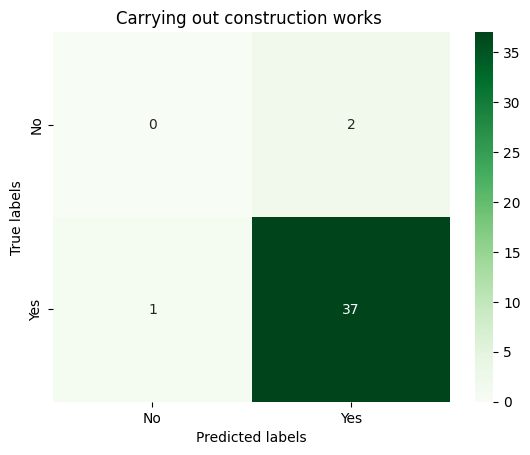

True Positives: 37, False Positives: 2, True Negatives: 0, False Negatives: 1 


Confusion Matrix for Class "Reconstruction of engineering systems":
 [[12  8]
 [ 5 15]]



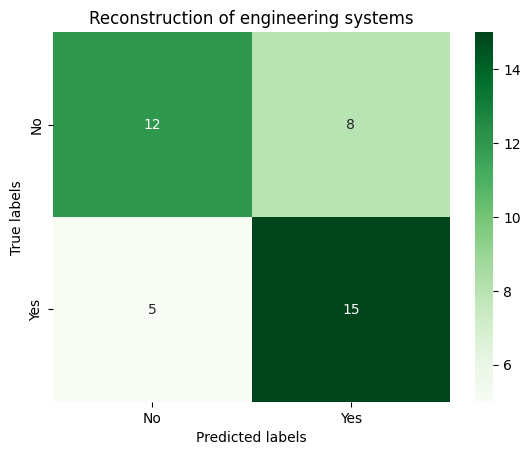

True Positives: 15, False Positives: 8, True Negatives: 12, False Negatives: 5 


Confusion Matrix for Class "Heat installation":
 [[37  0]
 [ 3  0]]



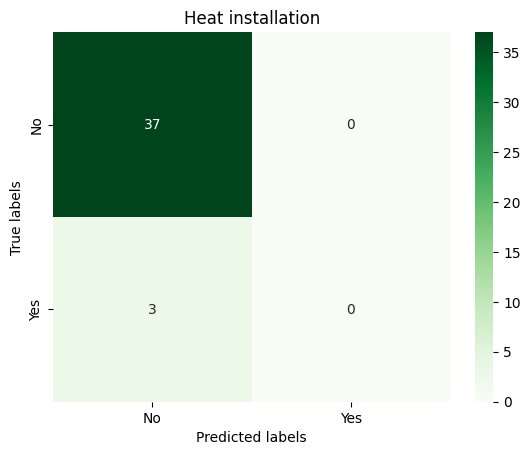

True Positives: 0, False Positives: 0, True Negatives: 37, False Negatives: 3 


Confusion Matrix for Class "Water heating system":
 [[39  0]
 [ 1  0]]



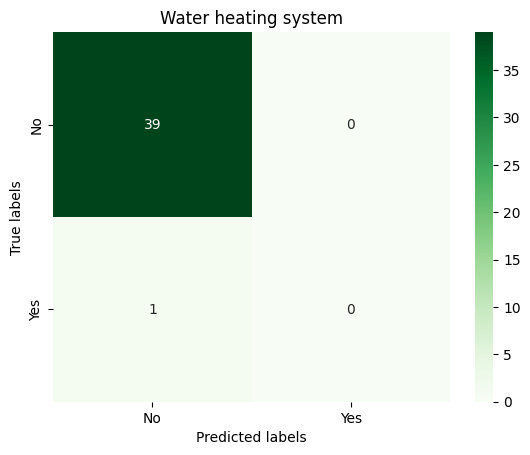

True Positives: 0, False Positives: 0, True Negatives: 39, False Negatives: 1 




In [20]:
###############################################################################
# Evaluation with various classification metrics (classification report)
###############################################################################

best_model = max(key for key, value in final_scores.items() if value == max(final_scores.values()))
best_model_index = list(models).index(best_model)

with open(f'{best_model}.pkl', 'rb') as f: clf = pickle.load(f)

# pipe = Pipeline([(best_model, models[best_model])])
# clf = GridSearchCV(estimator=pipe, param_grid=param_grid[best_model_index], cv=5, scoring='accuracy', n_jobs=-1)    
# clf.fit(train_X, train_Y) 

print(f"Mean performance of each parameter combination based on Cross Validation")
performance = pd.DataFrame(clf.cv_results_['params'])
performance["Score"] = clf.cv_results_['mean_test_score']
print(performance)

print("\nBest parameters set found on training set:")
print(clf.best_params_)

#evaluate and store scores of estimators of each category on validation set
score = clf.score(test_X, test_Y)
print("\nAccuracy:", score)
best_scores.append(score)

pred_Y = clf.predict(test_X)
print(metrics.classification_report(test_Y, pred_Y, digits=5))
confusion_matrices = multilabel_confusion_matrix(test_Y, pred_Y)
for i, cm in enumerate(confusion_matrices):
    print(f"Confusion Matrix for Class \"{target_cols[i]}\":\n {cm}\n")

    # ax, labels, title and ticks
    ax= plt.subplot();
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=plt.cm.Greens);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Predicted labels'); ax.set_ylabel('True labels');  
    ax.set_xticklabels(['No','Yes']); ax.set_yticklabels(['No','Yes'])
    plt.title(target_cols[i]); plt.show()
    print(f"True Positives: {cm[1,1]}, False Positives: {cm[0,1]}, True Negatives: {cm[0,0]}, False Negatives: {cm[1,0]} \n\n")

In [21]:
def model_predict(best_model,specs):
    with open(f'{best_model}.pkl', 'rb') as f: clf = pickle.load(f)
    pred_Y = clf.predict(specs)
    print(pred_Y)
    
specs = test_X[:1]
print(test_X[:1])
model_predict(best_model,specs)

    Building Total Area  Reference area  Above-ground floors  \
66             0.372583        0.244862                  0.5   

    Underground floor  Energy consumption before  Initial energy class   \
66                1.0                   0.267698                      2   

    Energy class after  
66                   2  
[[1 0 0 0]]
